## Importing data into python

### Import data file

In [1]:
import numpy as np

import hit_data_aligned as Data

hit_data = Data.hit_data

In the tutorial notebook the data was processed and stored in a handy library, which we will use now to look at the data

## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

Next we choose what data to plot, and how we want it to look like

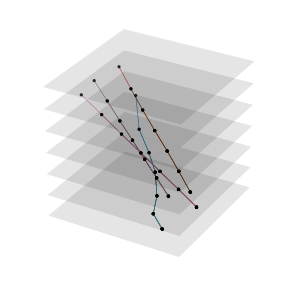

In [3]:
ppx, ppy = 0.02924, 0.02688 #Pixel pitches in x and y [mm]
plot_tracks = 3             #Plot the first 3 events
connect_hits = True         #Connects the hits
min_nop = 7                 #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*ppx,511*ppy,6*20 #Dimensions of the detector
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
#ax.set_box_aspect((3,3,3))      #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924)
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plot_counter = 0
#Plot the hits
for event in range(len(hit_data)):
    
    #Plot only events with the minimum amount of planes specified
    if (hit_data[event]['number_of_planes'] < min_nop): continue
        
    x_data, y_data, z_data = [], [], []
    
    for plane in range(7):
        
        #Skip over empty hits
        if (hit_data[event][plane]["XC"] == -1): continue
        
        #Put everything else into plottable arrays
        x_data.append(ppx*hit_data[event][plane]["XC"])
        y_data.append(ppy*hit_data[event][plane]["YC"])
        z_data.append(plane*20)

        ax.scatter3D(x_data,y_data,z_data,alpha=.7,color='black',marker='.')
        
        # OPTIONAL: Connect dots for Better visibility of Tracks
        if connect_hits:
            ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
        
    plot_counter+=1
    if plot_counter > plot_tracks: break
    

## Next steps

Next, the processed data is used to get a nice overview over some properties of the data. 
First, the number of events and the event quality is examined. We look at:
- the number n of firing detector planes in each event (n-plane-event)
- the number of hits, each plane registered
- the number of events with "holes". This means events, where the sequence of firing planes is not consecutive (e.g.: [1,2,5,6] instead of [1,2,3,4,5,6]) 

In [18]:
# container
holes=[[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]#holes[number of holes][n-plane-event], 
#e.g. holes[0][5] = number of 6-plane-events with 1 hole

holes_sum = [0,0,0,0,0,0,0] # number of n-plane-events, with at least 1 hole
#e.g. holes_sum[3] = number of 4-plane-events with at least 1 hole

n_p_e = [0,0,0,0,0,0,0] #number of n-plane-events (events in which n planes fired)
hits = [0,0,0,0,0,0,0] #number of hits per plane

#definition to exclude zeros from start and beginning of a list.
#Important, since for an event with the planes [2,3,5,6] we don't assign plane 0 and 1 as holes, but we do for plane 4.
def clear_seq(list):
    #check for value 1 in the last entry of the list
    while list[-1] == 1:
        list.pop(-1) #discard this entry from the list: [0,0,1] -> [0,0]
        
    #check for value 1 in the first entry of the list
    while list[0] == 1:
        list.pop(0)  #discard this entry from the list: [1,0,0] -> [0,0]

#loop over every event in hit_data
for event in range(len(hit_data)):

    ### count number of n-plane-events and the number of hits per plane (fill the corresponding container)
    n_p_e[hit_data[event]["number_of_planes"]-1] +=1
    #check which planes fired
    for i in range(7):
        #empty planes (without hits) are filled with a -1, so we check here, which planes of an event are not empty
        if hit_data[event][i]["XC"] != -1:
            hits[i] +=1
        

    ### count the holes total (depending on the number of involved planes)

    # look in events with number >=2 of involved planes (n-plane-events), since otherwise no "holes" are possible
    if hit_data[event]["number_of_planes"] >= 2:

        npe = hit_data[event]["number_of_planes"]# npe is now the number of firing planes in the selected event
        seq=[0,0,0,0,0,0,0]
        # look through every plane, if there is a hole
        for i in range(7):
            #-1 signs a plane without a hit in hit_data
            if hit_data[event][i]["XC"] == -1:
                #now a hole is marked as 1 in the sequence 
                seq[i]= 1
        #clear holes from the beginning and end of the sequence, e.g. [1,0,1,0,0,0,1] -> [0,1,0,0,0]
        clear_seq(seq)
        # now the number of empty planes (=holes) corresponds to the sum over the array seq.
        num_holes = sum(seq)

        #NOW: fill the container holes and holes_sum
        # if at least one hole is there
        if num_holes > 0:
            #increase total number of holes of an event with n planes (index n-1)
            holes_sum[npe-1] +=1
            if num_holes == 1:
                #increase number of 1-hole-events with n planes (index n-1)
                holes[0][npe-1] += 1
            elif num_holes == 2:
                #increase number of 2-hole-events with n planes (index n-1)
                holes[1][npe-1] += 1
            elif num_holes == 3:
                #increase number of 3-hole-events with n planes (index n-1)
                holes[2][npe-1] += 1
                if npe == 4:
                    print(hit_data[event]["chi2red"])


107796.32151267647
24908.279616430846
0.438966042540098
5852.413833062387
0.12378964708756432
0.29171320463217876
93.8359340891718
8.291973995341255
305.6170292698171
28267.124939829522
0.6208057942620816
32.07358277463001
507281.35003923613
24310.669590828078


Now we plot the results:

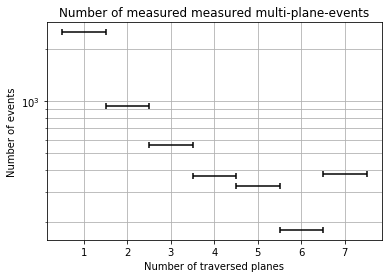

In [5]:
plane = np.arange(1, 8)  #index of the number of traversed planes fot the plots
n_p_e = np.array(n_p_e)  # converting list to np.array

# plotting n-plane-events
plt.figure()
plt.yscale("log")
plt.grid(which="both", axis="both")
plt.errorbar(plane, n_p_e, xerr=0.5, fmt='k', elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Number of traversed planes")
plt.ylabel("Number of events")
plt.title("Number of measured measured multi-plane-events")
plt.tick_params(axis='both')
#plt.legend()
plt.show()

In the plot above, the measured events are shown seperately according to the number of firing planes of the event.

The distribution shows a decreasing number of events for increasing number of traversed planes, with the exception of 7-plane-events. ALl in all, it looks similar to the expected distribution without scintillators, which is disussed here https://docs.google.com/document/d/1xDb3bH9edLU_2D5E9N_2bWHto8LFiBa47syD-zH3mbw/edit and to greater extend in the thesis of David Schledewitz.
Deviations from the distribution in the thesis could originate from the different setup with one scintillator in the bottom.


In the next plots we look at not consecutive sequences in the events (holes):

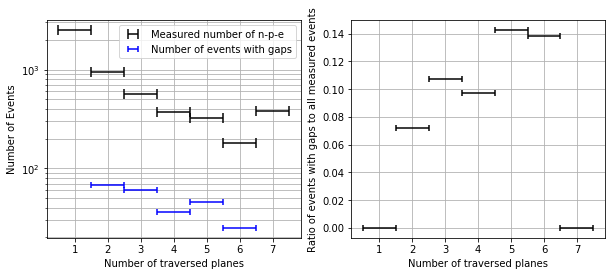

In [6]:
# plotting sum of holes and n-plane-events in plot 1
# plotting ratio of events with gaps to total number of n-plane-events in plot 2
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
ax1.set_yscale("log")
ax1.grid(which="both", axis="both")
ax1.errorbar(plane, n_p_e,xerr=0.5, fmt='k',elinewidth=1.5, lw=0, capsize=5, capthick=1.5, label= "Measured number of n-p-e")
ax1.errorbar(plane, holes_sum,xerr=0.5, fmt='b', elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "Number of events with gaps")

ax1.set_xlabel("Number of traversed planes")
ax1.set_ylabel("Number of Events" )
ax1.tick_params(axis='both')
#ax1.set_title("Mean rate of measured multi-plane-events, considering holes")
ax1.legend()#(fontsize=16)

ax2.errorbar(plane, holes_sum/(n_p_e+0.00000000001), xerr=0.5,fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)#+0.00000000001 quick fix to avoid divsion by zero
ax2.grid(which="both", axis="both")
ax2.set_xlabel("Number of traversed planes" )
ax2.set_ylabel("Ratio of events with gaps to all measured events" )
ax2.tick_params(axis='both')
#ax2.set_title("Ratio of events with gaps to total rate of n-plane-events")
plt.show()

Left we see the total number of evenets compared to the number of events with holes. Right we see the ratio of the events with holes over the total number of events.

It can be seen that most not consecutive events are already excluded during the track fitting process in the tutorial (https://github.com/DavidSchledewitz/Awesome_Cosmics/blob/main/3_Manual_Analysis/Tutorial.ipynb). But espacially for 5- and 6-plane-events, the share of around 14% of the total event number is higher than expected and has to be investigated further. Possible reasons might be a reduced efficiency, due to progressed aging/damage of one or two of the detectors. ALso geometrical missalignment might cause some non-consecutive events, especially at the edges of the detectors, as translational misalignment can be in the order of 1 mm.

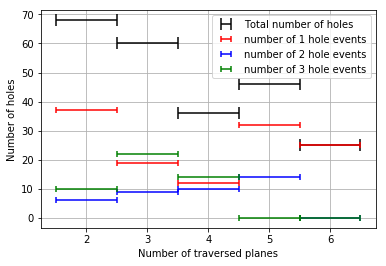

In [12]:
# plotting events with holes, dependent on the number of holes in an event
plt.figure()
plt.grid(which="both", axis="both")
#sum of hole events
plt.errorbar(plane[1:6], holes_sum[1:6], xerr=0.5,fmt='k', elinewidth=1.5, lw=0, capsize=6, capthick=1.5, label= "Total number of holes")
#1 hole events
plt.errorbar(plane[1:6], holes[0][1:6],xerr=0.5,fmt='r',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 1 hole events")
#2 hole events
plt.errorbar(plane[1:6], holes[1][1:6],xerr=0.5, fmt='b',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 2 hole events")
#3 hole events
plt.errorbar(plane[1:6],holes[2][1:6], xerr=0.5,fmt='green',elinewidth=1.5,lw=0,capsize=3, capthick=1.5, label= "number of 3 hole events")

plt.xlabel("Number of traversed planes")
plt.ylabel("Number of holes")
#plt.title("Number of holes")
plt.legend()
plt.show()

In the next plot here, we look at the distribution of holes over number of traversed planes, dependent on the number of holes in each event with at least one hole accuring.

THe plot shows that most not consecutive 2-, 5-, and 6-plane-events include only one hole, while 3- and 4-plane-events also have a bunch of events with 3 holes, which would lead to the plane sequence [0,2,4,6] for 4-plane-events. It would be interesting to investigate those events further to understand how those events can lead to a nice track, as they already passed the allignment cuts. Looking at the $\chi^2_{red}$ values of those 4-plane-events, we can see that most of them have huge values, while a few look just fine.

[107796; 
24908;
0,4;
5852;
0,1;
0,2;
93;
8;
305;
28267;
0,6;
32;
507281;
24310]

The bad tracks with high $\chi^2_{red}$ values might be caused by fake hits, while the good ones could be rare cases of inefficiency on multiple planes, but this has to be investigated further to tell the true reason.

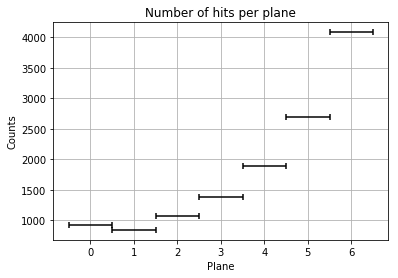

In [8]:
# plotting total number of hits
plt.figure()
plt.grid(which="both", axis="both")
plt.errorbar(plane-1, hits, xerr=0.5, fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Plane" )
#plt.ylabel("Mean rate $[1/s]$", )
plt.ylabel("Counts")
plt.tick_params(axis='both')
plt.title("Number of hits per plane")
# plt.legend()
plt.show()

This next plot shows the number of hits for each plane. The plot shows that the number of events from the increases significantly from 0 to 6 (with exception of the slightly higher events number in plane 0 compared to plane 1). This can be explained by the trigger system, since only one trigger is installed and placed right below plane 6. Therefore it is more likely for a muon, which hits the triggering scintillator to also hit plane 6 as it is to hit also the other planes.

In the next step we can look at the angular distribution of the cosmics. From there, the next task would be to find how the angle of a particle affects the detector response.

## Angular distribution

Now, the angular distribution and fit quality is examined:

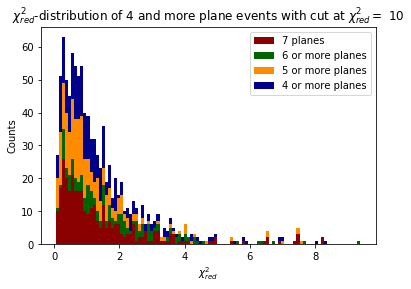

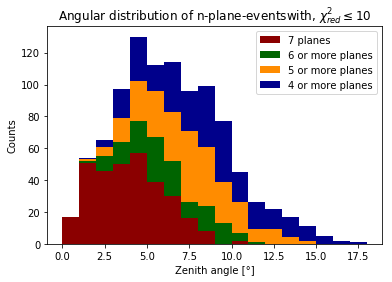

In [21]:
##container to store plot information

# here the incident angles of the events are stored
Phi =  np.array([])
# here the chi^2_red values of the 4-, 5-, 6-, 7-plane-events are stored seperately:
Chi2red4,Chi2red5,Chi2red6,Chi2red7 =  np.array([]),np.array([]),np.array([]),np.array([])
# here the incident angles of the 4-, 5-, 6-, 7-plane-events are stored seperately:
Phi4,Phi5,Phi6,Phi7 = np.array([]),np.array([]),np.array([]),np.array([])

chi2red = 10 ###############   choose chi2red cut for the data visualisation. 
#After looking at the fit quality in relation with the chi2red value, we found a value of 10 as a good indicator for a good track


# select an event(run over all events)
for event in range(len(hit_data)):

    #check that the event has at least 4 involved planes, since these are the most interesting for tracking, and hence further analysis
    if hit_data[event]["number_of_planes"] >= 4:

        #check, if chi2red < 10, to justify that the fit of the track in this event is good
        if hit_data[event]["chi2red"] <= chi2red:

            #extract the distances out of the two track points (tp1 and tp2) given. Those are then used to calculate the angle of the track
            d_x = hit_data[event]["Track_Point_2"][0]-hit_data[event]["Track_Point_1"][0]
            d_y = hit_data[event]["Track_Point_2"][1]-hit_data[event]["Track_Point_1"][1]
            d_z = hit_data[event]["Track_Point_2"][2]-hit_data[event]["Track_Point_1"][2]
            d_t = np.sqrt(d_x**2 + d_y**2)

            #calculate angle of the track
            phi = np.arctan(d_t/d_z)*360/(2*np.pi)
            Phi = np.append(Phi,phi)

            # look at the angles for events with different numbers of involved planes
            # also save the chi2red values of these tracks
            if hit_data[event]["number_of_planes"]==4:
                Phi4 = np.append(Phi4,phi)
                Chi2red4 = np.append(Chi2red4,hit_data[event]["chi2red"])
            if hit_data[event]["number_of_planes"]==5:
                Phi5 = np.append(Phi5,phi)
                Chi2red5 = np.append(Chi2red5,hit_data[event]["chi2red"])
            if hit_data[event]["number_of_planes"]==6:
                Phi6 = np.append(Phi6,phi)
                Chi2red6 = np.append(Chi2red6,hit_data[event]["chi2red"])
            if hit_data[event]["number_of_planes"]==7:
                Phi7 = np.append(Phi7,phi)
                Chi2red7 = np.append(Chi2red7,hit_data[event]["chi2red"])


#######################---PLOTS   PLOTS   PLOTS   PLOTS---#############################
#plt.figure()
#plt.hist(Phi,bins= 14 ,range=(0,28), color= "darkblue")#, label="Selected tracks, $\chi^2_{red} \leqslant$ "+str(chi2red))
#plt.title("Angular distribution of 4 or more plane events with $\chi^2_{red} \leqslant$ "+str(chi2red))
#plt.xlabel("Zenith angle [°]")
#plt.ylabel("Counts")
##plt.legend()
#plt.show()

plt.figure()
plt.hist((Chi2red7,Chi2red6,Chi2red5,Chi2red4), bins=100,label=("7 planes","6 or more planes","5 or more planes","4 or more planes" )
        , color= ("darkred","darkgreen","darkorange","darkblue"), histtype="barstacked")#, label="Selected tracks, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12))+" and "+str(chi21)+" to "+str(chi22)
#plt.hist(Chi,range=(0,100), bins=50, label="Selected tracks, $\phi$ in range "+str(phi111)+" to "+str(phi142))
plt.title("$\chi^2_{red}$-distribution of 4 and more plane events with cut at $\chi^2_{red} =$ "+str(chi2red))# in range "+str(chi11)+" to "+str(chi12))
plt.xlabel("$\chi^2_{red}$")
plt.ylabel("Counts")
plt.tick_params(axis='both')
plt.legend()
plt.show()

plt.figure()
plt.hist(([Phi7,Phi6,Phi5,Phi4]), bins= 18 ,range=(0,18),label=("7 planes","6 or more planes","5 or more planes","4 or more planes" )
         , color= ("darkred","darkgreen","darkorange","darkblue"), histtype="barstacked")#, weights=(np.ones(len(Phi7)),np.ones(len(Phi6))/2,np.ones(len(Phi5))/3,np.ones(len(Phi4))/4))
plt.title("Angular distribution of n-plane-eventswith, $\chi^2_{red}\leq$"+str(chi2red))#, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12), fontsize = 24)
plt.xlabel("Zenith angle [°]")
plt.ylabel("Counts")
plt.tick_params(axis='both')
plt.legend()

We see here the $\chi^2_{red}$ and angular distribution for 4, 5, 6, 7-plane events (4,5,6 each include the events with more involved planes to plot them nicely). 
The first plot shows that the $\chi^2_{red}$ distribution indicates a nice fit quality.

If we look at the angular distribution in the second plot, a similar distribution to the distribution of David Schledewitz bachelorthesis is shown:

![angular_chi100_4_5_6_7.png](attachment:angular_chi100_4_5_6_7.png)

If we remember that muons follow an cos²(theta)-distribution, we can see this distribution especially in the distribution of 7-plane-events, except for the first bin (1 degree) and to larger angles constrained by the detector geometry.
As explained in more detail in the thesis, the distributions of 4-, 5-, and 6-plane-events is different from the cos²(theta)-distribution, since the detector geometry does not allow for small angle tracks with less than 7 planes (if we assume a very high detection efficiency of the detectors, which is given). This can be observed especially up to an angle of 3°, where 7-plane-events are dominating the distribution.

The only issue in this distribution is the first bin , since we would expect to have the highest number of events in this bin due to the cos²(theta)-distribution. The most probable reason for that is that the telescope is not placed truely vertically, facing the sky, but slightly tilted. And since the allignment did not account for rotation in any axis, the tilted geometry could explain the low number of events in the first bin.
Another piece of evidence can be seen, if we look at the tracks from the side with Maurice Donners plotting:

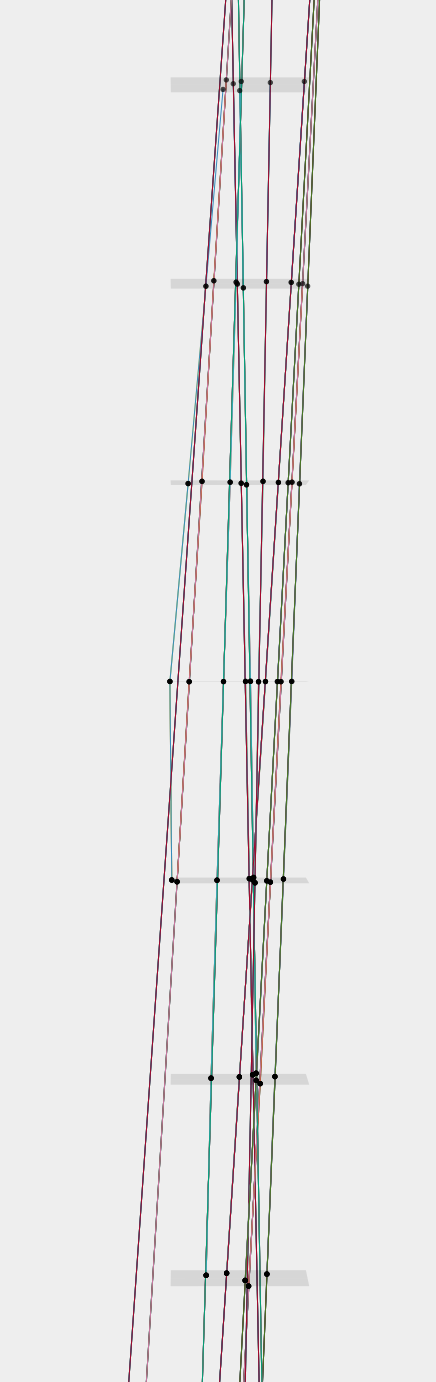

By calculating the mean azimuthal angle an the corresponding mean zenith angle, we can account for this rotation.
This is done in the next step:

## Angle Correction

To correct the angle, we need the azimuthal ($\varphi$) dependence of the zenith ($\theta$) angle.
Since the detector is symetric (with regard to $\theta(\varphi)$ and $\theta(-\varphi)$), we can then find the bias by calculating the mean angle $\theta(\varphi)$.

In [84]:
###Calculating mean angle theta(phi)

#container to save all angles theta and phi correlated to each other
Theta_cor = np.array([])
Phi_cor   = np.array([])
d_X       = np.array([])
d_Y       = np.array([])
d_Z       = np.array([])

def Mean(val, w):#weighted mean
    mean = np.mean(val)
    stat = np.sqrt(1/(val.size*(val.size-1)) *np.sum((mean-val)**2))  # statistischer Fehler
    print("Meanvalue:" , mean, " +- ", stat, "stat.")
    return mean, stat 

#defenition to calculate the angles theta and phi of one event
def theta_phi(x,y,z):
    #first, calculate the total distance of the two trackpoints
    r     = np.sqrt(x**2 + y**2 + z**2)
    #Now we calculate the angles using the functions given in the math package.
    #For comprehension look up the functions on spherical coordinates on wiki
    phi   = np.arctan2(y,x) #*180/np.pi #in degree
    theta = np.arccos(z/r)  #*180/np.pi #in degree
    
    return theta,phi

# select an event(run over all events)
for event in range(len(hit_data)):

    #check that the event has at least 4 involved planes, since these are the best for tracking
    if hit_data[event]["number_of_planes"] >= 4:

        #check chi2red, to see if the fit of the track in this event is good. We wont take the bad tracks here
        if hit_data[event]["chi2red"] <= chi2red:

            #extract the distances out of the two track points (tp1 and tp2) given. Those are then used to calculate the angle of the track
            d_x = hit_data[event]["Track_Point_2"][0]-hit_data[event]["Track_Point_1"][0]
            d_y = hit_data[event]["Track_Point_2"][1]-hit_data[event]["Track_Point_1"][1]
            d_z = hit_data[event]["Track_Point_2"][2]-hit_data[event]["Track_Point_1"][2]
            theta_cor,phi_cor=theta_phi(d_x, d_y, d_z)

            #fill in container
            d_X,d_Y,d_Z = np.append(d_X,d_x), np.append(d_Y,d_y), np.append(d_Z,d_z)
            Theta_cor = np.append(Theta_cor,theta_cor)
            Phi_cor = np.append(Phi_cor,phi_cor)

            
            
            
x, dx = Mean(d_X,0)
y, dy = Mean(d_Y,0)
z, dz = Mean(d_Z,0)

theta_phi(x,y,z)

ex_t, d_ex = Mean(d_X* np.sin(Theta_cor)/np.sqrt(d_X*d_X+d_Y*d_Y),0)
ey_t, d_ey = Mean(d_Y* np.sin(Theta_cor)/np.sqrt(d_X*d_X+d_Y*d_Y),0)

r_t = np.sqrt(ex_t*ex_t + ey_t*ey_t)
d_r_t = np.sqrt(d_ex*d_ex*ex_t*ex_t + ey_t*ey_t*d_ey*d_ey/(ey_t*ey_t + ex_t*ex_t))

print("Phi: ",np.arctan2(ey_t,ex_t)*180/np.pi," +- ",np.sqrt(d_ey*d_ey*ex_t*ex_t + ey_t*ey_t*d_ex*d_ex)/(ey_t*ey_t + ex_t*ex_t)*180/np.pi)
print("Theta: ",np.arcsin(r_t)*180/np.pi," +- ",np.sqrt(-d_r_t*d_r_t/(r_t*r_t-1))*180/np.pi)



Meanvalue: -9.18768621109756  +-  0.5778556305265529 stat.
Meanvalue: -9.927591389717028  +-  0.33178774809327755 stat.
Meanvalue: 197.22562430665423  +-  0.6946180130171152 stat.
Meanvalue: -0.04593843105548782  +-  0.0028892781526327644 stat.
Meanvalue: -0.049637956948585145  +-  0.0016589387404663876 stat.
Phi:  -132.7833285209456  +-  2.0342756308202006
Theta:  3.878064284250356  +-  0.0703342889966845


In [ ]:
preliminary_mean = [3.9234709091188367, -132.7833285209456]

By implementing this bias angle into the allignment process of the tutorial, we get a corrected dataset, which is used in the following.